# Thực hành Nhập môn Máy học - Final Lab - Multilayer Perceptron

Thông tin nhóm:
- Huỳnh Quang Trung - 20280108
- Trần Tuấn Thái - 20280082

Bài làm được thực hiện trên Google Colab.

---

Description:
- Apply all knowledge and techniques that you have learned for this
- You must organize your notebook based on the Homework
- Should not drop Na, drop missing
- Models: compare all models that you have learned or practiced
- Can use pytorch & tensorflow
- Automl (should not use)

Deadline:
 - 3-4 weeks - (2023-07-04)

# Setup and import modul

In [ ]:
!pip install keras_tuner
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from datetime import datetime

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import math
import keras_tuner as kt
import matplotlib.pyplot as plt



from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading Dataset

In [ ]:
PATH = "/content/drive/MyDrive/Final NMMH/Banking.csv"
df = pd.read_csv(PATH)

In [ ]:
df.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [ ]:
df.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

# Data Analysis & Data Preprocessing

Tạo một bản copy của file dữ liệu gốc để phân tích và xử lý

In [ ]:
data = df.copy()

Đầu tiên, ta cần bỏ đi cột `Loan_ID`, là một mã định danh cho từng người đi vây mang thông tin riêng tư của khách hàng.

In [ ]:
data = data.drop(['Loan_ID'], axis=1)

### Phân tích và xử lý các cột categorical

Ta lấy ra tên các cột categorical và đưa vào 1 list cho tiện xử lý:

In [ ]:
categorical_columns = data.select_dtypes(exclude=['int', 'float']).columns.tolist()
categorical_columns.remove('Loan_Amount_Requested') # Ta phải xóa đi cột Loan_Amount_Requested vì thực chất đây là một cột numerical đang ở sai định dạng.
categorical_columns.append('Interest_Rate') # Ta thêm cột Interest_Rate vào vì đây là cột phân loại loại lãi suất cho vay

In [ ]:
categorical_columns

['Length_Employed',
 'Home_Owner',
 'Income_Verified',
 'Purpose_Of_Loan',
 'Gender',
 'Interest_Rate']

In [ ]:
data[categorical_columns].isna().sum()

Length_Employed     7371
Home_Owner         25349
Income_Verified        0
Purpose_Of_Loan        0
Gender                 0
Interest_Rate          0
dtype: int64

Với các cột categorical, ta có các vấn đề ở 2 cột là `Home_Owner ` và `Length_Employed ` khi 2 cột này xuất hiện rất nhiều các missing values.

#### Cột Length_Employed

In [ ]:
data.Length_Employed.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

<Axes: xlabel='Length_Employed', ylabel='count'>

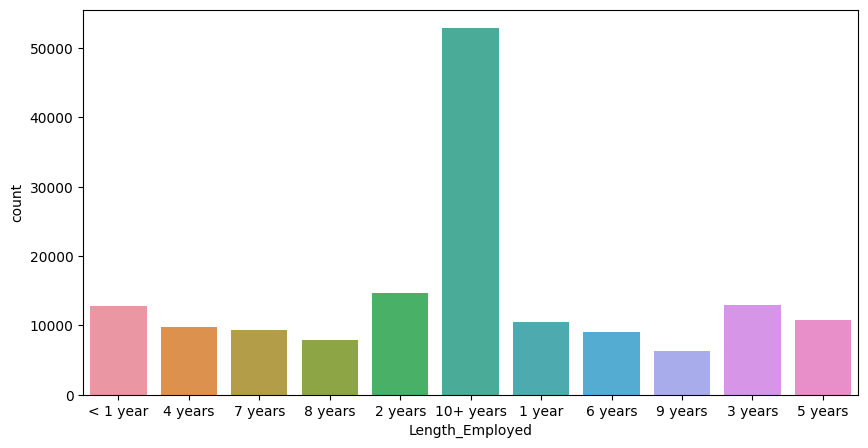

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Length_Employed')

Dựa vào biểu đồ countplot phía trên, ta nhận xét được rằng phần lớn người đi vay là những người có kinh nghiệm trên 10 năm làm việc.

Theo quan sats trước đó thì có 7371 giá trị missing values trong cột `Length_Employed`, vì vậy ta sẽ quyết định fill các giá trị missing values này thành giá trị mode ở phần data preprocessing.

#### Cột Home_Owner

In [ ]:
data.Home_Owner.unique()

array(['Rent', 'Mortgage', nan, 'Own', 'Other', 'None'], dtype=object)

Trong cột `Home_Ower` có các giá trị đặc biệt là NaN và None, đây có thể là các thông tin bị thiếu trong quá trình thu thập dữ liệu. Trước tiên, ta sẽ thay thế giá trị 'None' trong cột này thành giá trị NaN.

In [ ]:
# Thay thế giá trị 'None' thành NaN
data['Home_Owner'] = data['Home_Owner'].replace('None', np.nan)

Xem qua biểu đồ countplot:

<Axes: xlabel='Home_Owner', ylabel='count'>

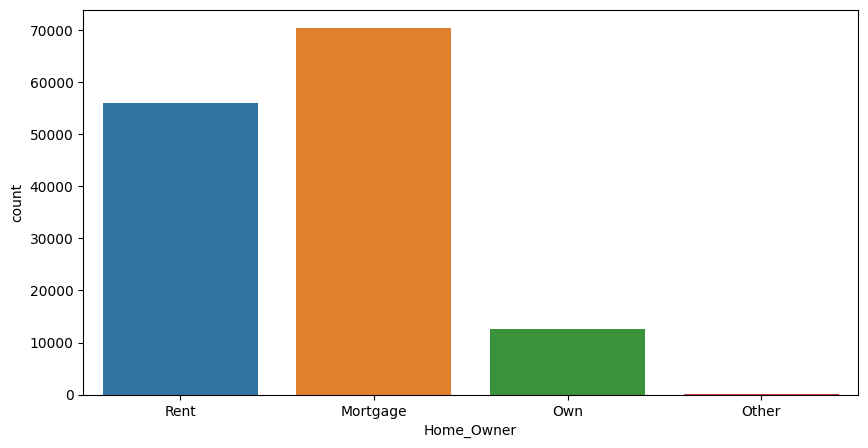

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Home_Owner')

Phần lớn người đi vay ngân hàng đều sở hữu một căn nhà thuế chấp hoặc ở một căn nhà thuê.

<Axes: xlabel='Home_Owner', ylabel='count'>

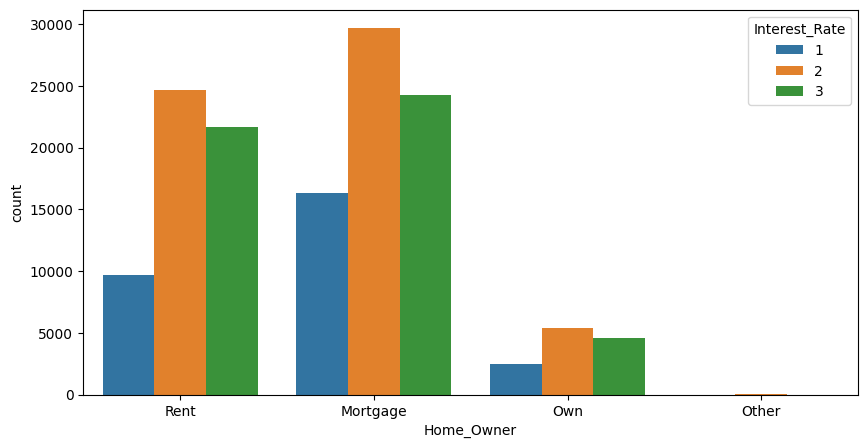

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Home_Owner', hue='Interest_Rate')

Phần lớn người có nhà thế chấp, nhà thuê hoặc sở hữu nhà riêng đều sẽ được cho vay với lãi suất loại 2.

#### Cột Income_Verified

In [ ]:
data.Income_Verified.unique()

array(['not verified', 'VERIFIED - income', 'VERIFIED - income source'],
      dtype=object)

Ta thấy rằng các giá trị trong cột này đã chính xác, bao gồm:
- not verified
- VERIFIED - income
- VERIFIED - income source

<Axes: xlabel='Income_Verified', ylabel='count'>

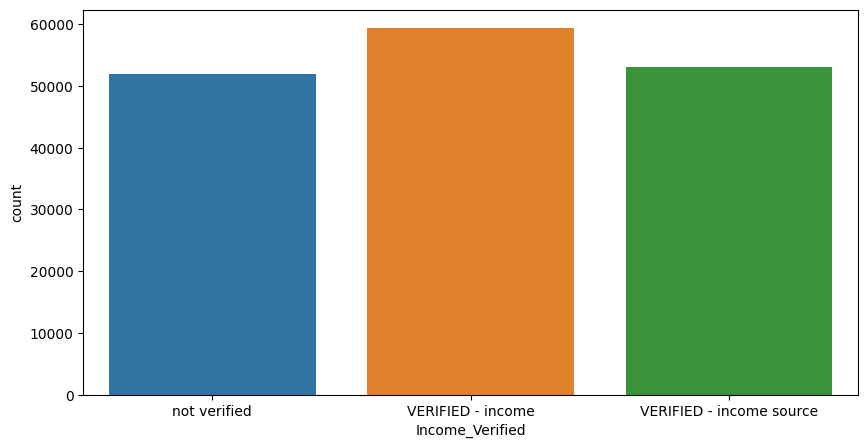

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Income_Verified')

Các loại xác minh nguồn thu nhập phân bố đồng đều với nhau trong tập dữ liệu.

<Axes: xlabel='Income_Verified', ylabel='count'>

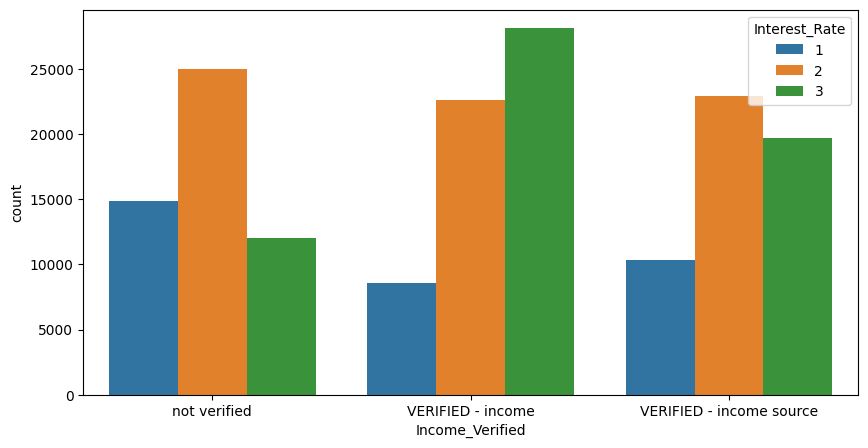

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Income_Verified', hue='Interest_Rate')

Cột `Income_Verified` này không có các giá trị missing values nào.

#### Cột Purpose_Of_Loan

In [ ]:
data.Purpose_Of_Loan.unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype=object)

Các giá trị trong cột này cung cấp mục đích của người đi vay và ta thấy các lý do đều không có giá trị nào là sai hoặc bất thường.

<Axes: xlabel='Purpose_Of_Loan', ylabel='count'>

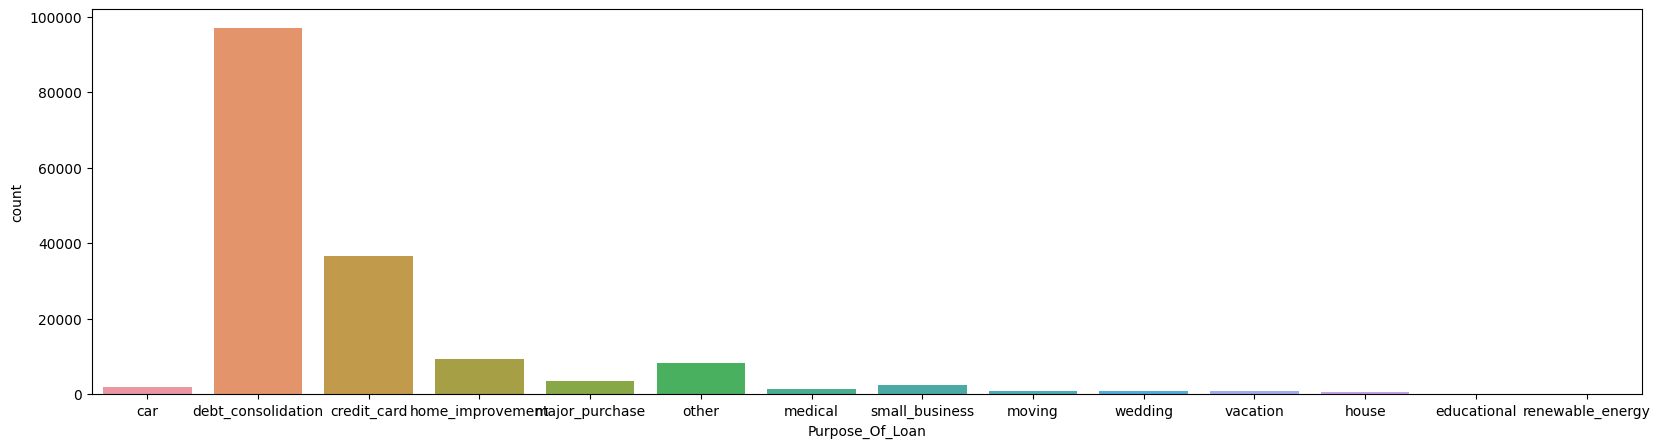

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(data = data, x = 'Purpose_Of_Loan')

Ta thấy phần lớn người đi vay đều dùng số tiền này cho mục đích là trả nợ.

Cột Purpose_Of_Loan này cũng không có giá trị missing values nào.

#### Cột Gender

In [ ]:
data.Gender.unique()

array(['Female', 'Male'], dtype=object)

Không có giá trị bất thường trong cột `Gender`, trong đó chỉ tồn tại 2 giới tính là Male và Female.

<Axes: xlabel='Gender', ylabel='count'>

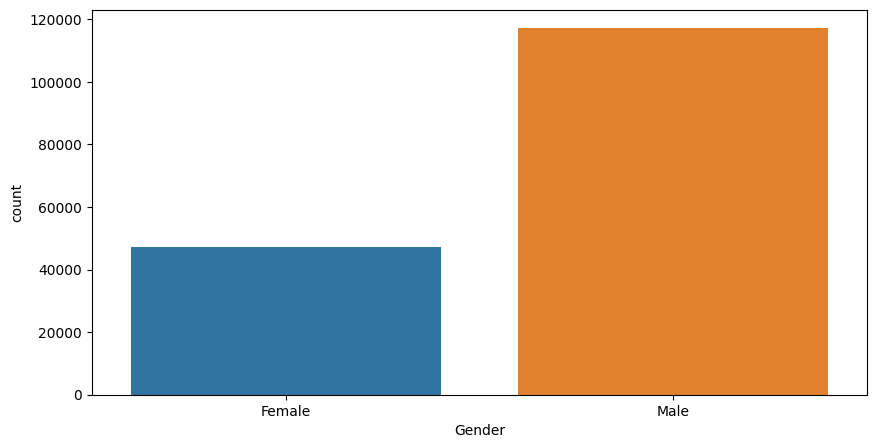

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Gender')

Phần lớn người đi vay tiền là nam giới.


<Axes: xlabel='Gender', ylabel='count'>

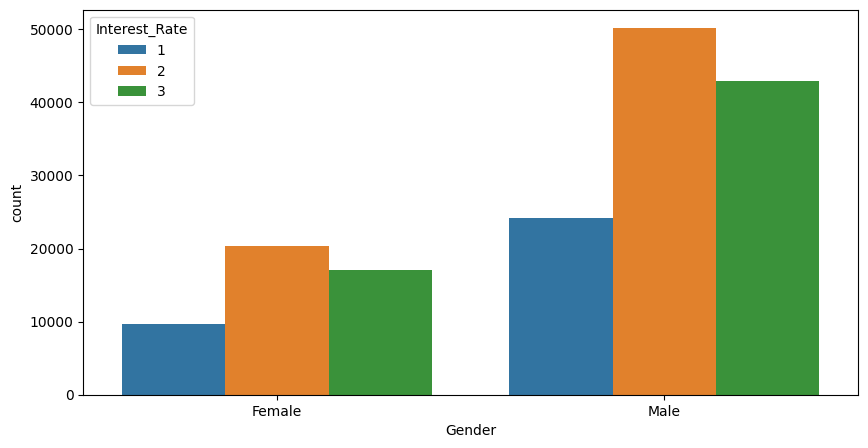

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Gender', hue='Interest_Rate')

Cột `Gender` cũng không có các giá trị missing values nào.

#### Cột Interest_Rate

<Axes: xlabel='Interest_Rate', ylabel='count'>

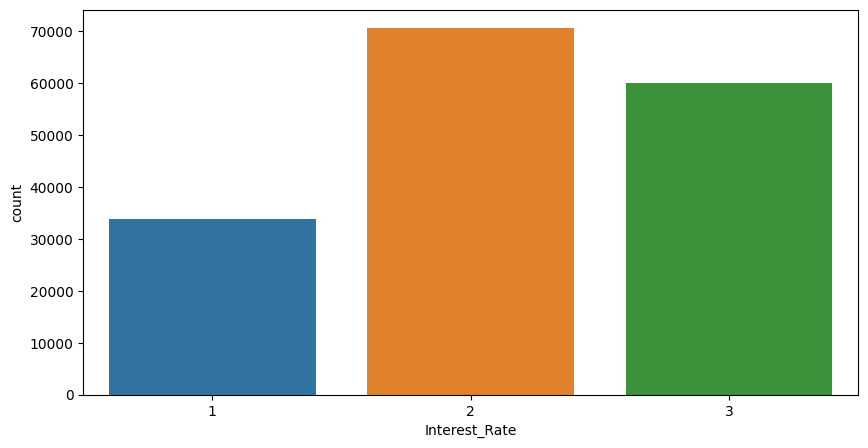

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data, x = 'Interest_Rate')

Ta thấy được rằng đây là một tập dữ liệu bị mất cân bằng giữa các lớp khi lớp 2 và 3 có số lượng mẫu hơn gấp 2 lần số lượng mẫu ở lớp 1.

### Phân tích các cột numerical

In [ ]:
numerical_columns = data.select_dtypes(include=['int', 'float']).columns.to_list()
numerical_columns

['Annual_Income',
 'Debt_To_Income',
 'Inquiries_Last_6Mo',
 'Months_Since_Deliquency',
 'Number_Open_Accounts',
 'Total_Accounts',
 'Interest_Rate']

In [ ]:
numerical_columns.append('Loan_Amount_Requested') # Ta thêm cột Loan_Amount_Requested vào các cột numerical
numerical_columns.remove('Interest_Rate') # Ta xóa cột Interest_Rate do nó là cột phân loại lãi suất cho vay

Tiếp theo, ta có trường hợp cột Loan_Amount_Requested là cột thể hiện mức vay mong muốn của người đi vay, nó biểu diễn một miền giá trị là số nhưng lại đang không ở đúng kiểu dữ liệu, vì vậy ta sẽ chuyển nó sang kiểu dữ liệu `float`.

In [ ]:
data['Loan_Amount_Requested'] = data['Loan_Amount_Requested'].str.replace(',', '').astype(float)

Ta xem qua thông tin thông kê mô tả của các cột numerical:

In [ ]:
data[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Annual_Income,139207.0,73331.159434,60377.498294,4000.0,45000.00,63000.00,88697.50,7500000.00
Debt_To_Income,164309.0,17.207189,7.845083,0.0,11.37,16.84,22.78,39.99
Inquiries_Last_6Mo,164309.0,0.781698,1.034747,0.0,0.00,0.00,1.00,8.00
Months_Since_Deliquency,75930.0,34.229356,21.761180,0.0,16.00,31.00,50.00,180.00
Number_Open_Accounts,164309.0,11.193818,4.991813,0.0,8.00,10.00,14.00,76.00
Total_Accounts,164309.0,25.067665,11.583067,2.0,17.00,23.00,32.00,156.00
Loan_Amount_Requested,164309.0,14349.336920,8281.868700,500.0,8000.00,12075.00,20000.00,35000.00


Ccá cột này đều không có cột nào mang giá trị âm nhưng lại có 4 cột mang giá trị nhỏ nhất là 0:
- `Debt_To_Income`: Cột này là tỉ số giữa tổng số tiền thanh toán nợ hàng tháng của người vay trên tổng nghĩa vụ nợ đem chia cho thu nhập hàng tháng tự báo cáo của người này. Như vậy cột này có thể là 0 nếu như người này không có bất kỳ khoản nợ nào hiện tại.
- `Inquiries_Last_6Mo`: Số lần các tổ chức tín dụng yêu cầu kiểm tra hồ sơ tín dụng của người vay trong 6 tháng qua. Cột này cũng có thể mang giá trị 0.
- `Months_Since_Deliquency`: Số tháng kể từ lần trả nợ cuối cùng, cột này cũng có thể mang giá trị 0.
- `Number_Open_Accounts`: Số hạn mức tín dụng đã mở trong hồ sơ tín dụng của người đi vay, cột này cũng có thể mang giá trị 0.

Như vậy, các giá trị trong từng cột numerrical đều đã được thể hiện trong miền giá trị chính xác.

Tiếp theo ta sẽ xem qua biểu đồ boxplot của các cột này:

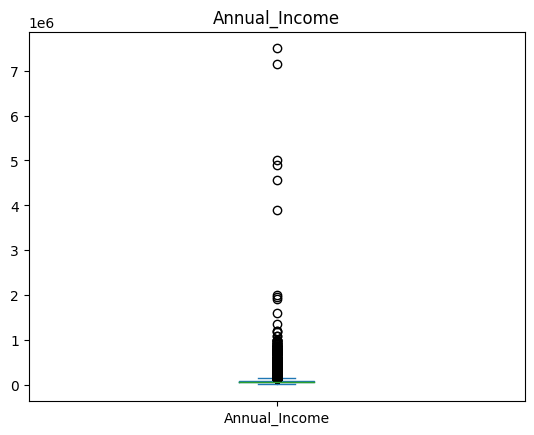

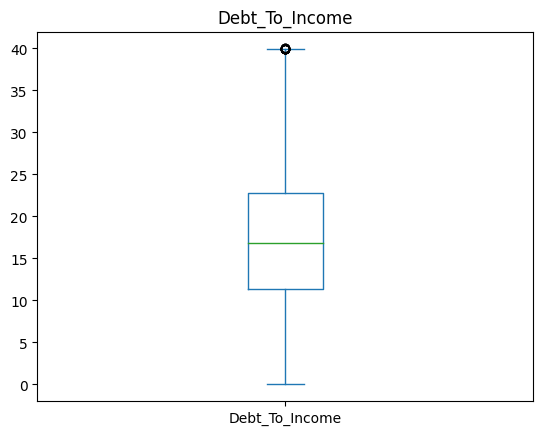

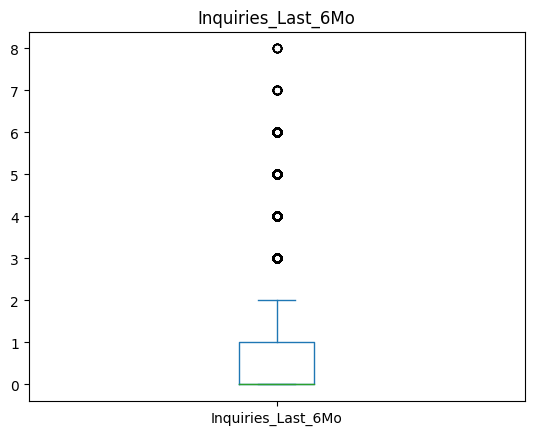

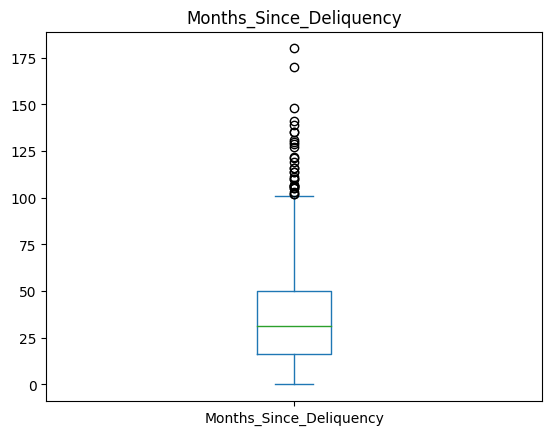

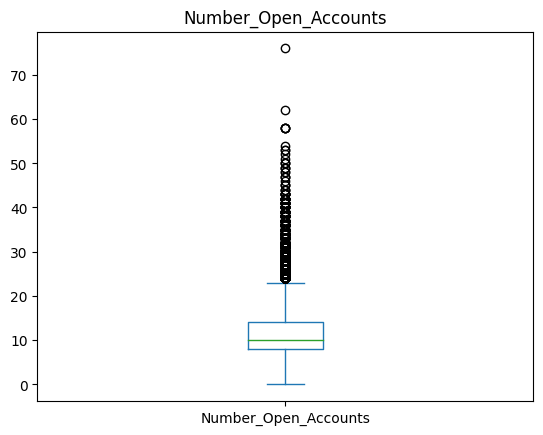

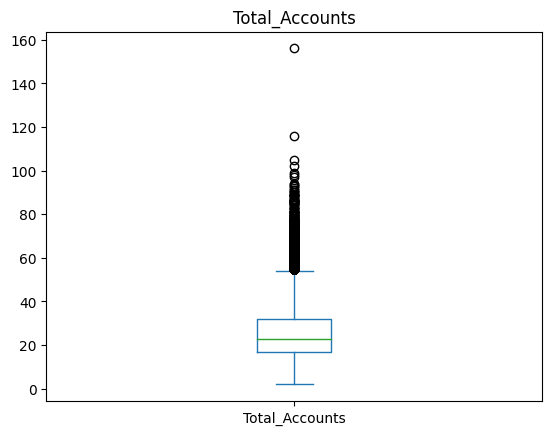

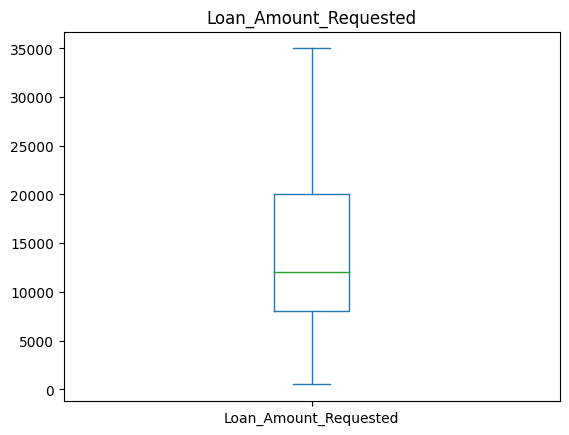

In [ ]:
def draw_boxplot(dataframe, column_names):
    for column in column_names:
        plt.figure()  # Tạo một đồ thị mới cho mỗi cột
        dataframe[column].plot(kind='box')
        plt.title(column)
        plt.show()

draw_boxplot(data, numerical_columns)

Các cột numerical này cũng mang các giá trị outlier cần xử lý (đặc biệt là cột Annual_Income) vì thế ta cũng sẽ quyết định thay thế hết các giá trị outlier này thành NaN để chờ cho bước xử lý tiếp theo. Ta sẽ thay thế các giá trị nằm ngoài khoảng giá trị [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] thành NaN:

In [ ]:
def replace_outliers(df, columns):
    for col in columns:
        # Tính phạm vi IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # Xác định giá trị ngoài cận
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Thay thế giá trị ngoài cận bằng np.NaN
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), np.NaN, df[col])

replace_outliers(data, numerical_columns)

Tiếp theo, ta sẽ xem qua các missing values tồn tại trong các cột này:

In [ ]:
data.shape

(164309, 13)

In [ ]:
data[numerical_columns].isna().sum()

Annual_Income              30983
Debt_To_Income                12
Inquiries_Last_6Mo         12276
Months_Since_Deliquency    88409
Number_Open_Accounts        3754
Total_Accounts              3099
Loan_Amount_Requested          0
dtype: int64

Có 2 cột có số lượng missing values rất nhiều, đó là cột `Annual_Income` và `Months_Since_Deliquency `, trong đó cột `Months_Since_Deliquency ` là nhiều nhất với 88379 giá trị bị thiếu, hơn một nửa bộ dữ liệu.

### Data Preprocessing

Bước tiếp theo, ta sẽ xử lý hết các missing values có trong tập dữ liệu, ở đây sẽ có 2 cách xử lý:
- Điền các giá trị bị thiếu trong các cột categorical bằng giá trị mode trong cột.
- Điền các giá trị bị thiếu trong các cột numerical bằng cách sử dụng IterativeImputer từ thư viện scikit-learn.

In [ ]:
# Viết hàm fill NaN cho các cột categorical

def fillna_categorical_mode(df, categorical_columns):
    for column in categorical_columns:
        # Lấy giá trị mode của cột
        mode_value = df[column].mode().iloc[0]
        # Fill giá trị NaN bằng mode
        df[column].fillna(mode_value, inplace=True)

In [ ]:
# Viết hàm fill NaN cho các cột numerical.

def fillna_numerical(df, numerical_columns):
    # Tạo DataFrame tạm thời chỉ chứa các cột numerical
    df_numerical = df[numerical_columns]

    # Khởi tạo IterativeImputer
    imputer = IterativeImputer(random_state=0)

    # Fill giá trị NaN trong DataFrame tạm thời
    df_filled = pd.DataFrame(imputer.fit_transform(df_numerical), columns=numerical_columns)

    # Gán lại các cột đã fill vào DataFrame gốc
    df[numerical_columns] = df_filled

Viết hàm preprocessing, bao gồm tất cả các bước thay đổi trên bộ dữ liệu từ những phân tích trên, cụ thể chúng ta đã có những bước xử lý sau:
- Xóa bỏ cột `Loan_ID`.
- Thay thế các giá trị 'None' trong cột `Hone_Owner` thành Nan.
- Chuyển cột Loan_Amount_Requested sang dạng kiểu float cho đúng định dạng.
- Thay thế các giá trị outlier trong các cột numerical thành NaN.
- Thay thế các giá trị NaN trong các cột categorical thành giá trị mode.
- Thay thế các giá trị NaN trong các cột numerical bằng cách sử dụng thư viện IterativeImputer của scikit-learn.
- Sau khi sử dụng IterativeImputer để dự đoán và fill vào các NaN thì ở các cột `Inquiries_Last_6Mo`,	`Months_Since_Deliquency`, `Number_Open_Accounts` và `Total_Accounts` sẽ xuất hiện các số thập phân, mà các cột này chỉ chứa các giá trị là số nguyên, vì vậy ta sẽ làm tròn lên các giá trị thập phân này.

In [ ]:
def preprocessing(dataframe, categorical_columns, numerical_columns):

    df = dataframe.copy()

    df = df.drop(['Loan_ID'], axis=1) # Xóa cột ID của khách hàng
    # Thay thế giá trị 'None' trong cột Home_Owner thành NaN
    df['Home_Owner'] = df['Home_Owner'].replace('None', np.nan)
    # Chuyển cột Loan_Amount_Requested sang dạng kiểu float
    df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].str.replace(',', '').astype(float)

    # Thay thế các giá trị outlier trong các cột numerical thành NaN
    replace_outliers(df, numerical_columns)

    # Thay thế các giá trị NaN trong các cột categorical thành giá trị mode
    fillna_categorical_mode(df, categorical_columns)
    # Thay thế các giá trị NaN trong các cột numerical bằng thư viện IterativeImputer
    fillna_numerical(df, numerical_columns)

    # Làm tròn lên các cột mang giá trị số nguyên
    df['Inquiries_Last_6Mo'] = df['Inquiries_Last_6Mo'].apply(lambda x: math.ceil(x))
    df['Months_Since_Deliquency'] = df['Months_Since_Deliquency'].apply(lambda x: math.ceil(x))
    df['Number_Open_Accounts'] = df['Number_Open_Accounts'].apply(lambda x: math.ceil(x))
    df['Total_Accounts'] = df['Total_Accounts'].apply(lambda x: math.ceil(x))


    return df

In [ ]:
preprocessing_data = preprocessing(df.copy(), categorical_columns, numerical_columns)

## Data Feature Engineering

Ta lấy get_dummies() các cột categorical

In [ ]:
def feature_engineering(dataframe):
    engineered_df = dataframe.copy()

    categorical_cols = [feature for feature in engineered_df.columns if engineered_df[feature].dtype == "O"] # Lấy tên các cột categorical
    numerical_cols = [feature for feature in engineered_df.columns if engineered_df[feature].dtype != "O"] # Lấy tên các cột numerical

    categorical_data = pd.get_dummies(engineered_df[categorical_cols]) # Lấy get_dummies() các cột categorical
    numerical_data = engineered_df[numerical_cols]

    engineered_df = pd.concat([categorical_data, numerical_data], axis=1)

    return engineered_df

In [ ]:
engineered_data = feature_engineering(preprocessing_data)

<Axes: xlabel='Interest_Rate', ylabel='count'>

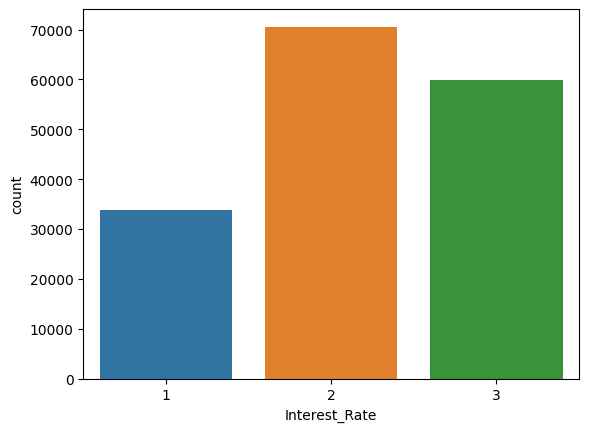

In [ ]:
import seaborn as sns
sns.countplot(data = engineered_data, x = 'Interest_Rate')

# Prepare X, y

In [ ]:
def prepare_X_y(df):
    feature_names = df.columns.tolist()
    feature_names.remove("Interest_Rate")

    X = df[feature_names].values
    y = df.Interest_Rate.values
    return X, y

In [ ]:
X, y = prepare_X_y(engineered_data)

# Train-test split

In [ ]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

# Build Model

## StandardScaler

Áp dụng StandardScaler()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(trainX)
X_test_scaled = scaler.transform(testX)

## Tensorflow MLP model

Tiếp theo, ta sẽ xây dựng một mạng neuron fully connected (Multilayer Perceptron) với thư viện tensorflow.

Đối với tf.keras.Sequential, chúng ta cần mã hóa các lớp trong đầu ra trong phạm vi từ 0 cho đến n_class - 1. Do đó, để làm điều này ta sẽ sử dụng LabelEncoder() để mã hóa biến target.

In [ ]:
label_encoder = LabelEncoder()
trainY_encoder = label_encoder.fit_transform(trainY)
testY_encoder = label_encoder.transform(testY)

Tiếp theo, ta khởi tạo một mô hình tuần tự (Sequential model) trong TensorFlow và Keras. Mô hình tuần tự là một dạng mô hình mạng nơ-ron feedforward, trong đó các layer được xếp chồng lên nhau tuần tự theo thứ tự từ đầu vào đến đầu ra. Trong trường hợp này, chúng ta sẽ xây dựng một mô hình gồm các layer kết nối đầy đủ (Dense layer).

Lớp đầu tiên sẽ một lớp Dense bao gồm 100 node với đầu vào là số lượng feature của tập dữ liệu cùng với hàm kích hoạt là relu, một hàm phi tuyến được sử dụng rộng rãi. Các tầng tiếp theo sẽ bao gồm 300, 200, 100 và cuối cùng là 3 node đầu ra với hàm kích hoạt là softmax sẽ đưa các output về xác suất ứng với mỗi lớp và các xác suất này sẽ có tổng là 1.

Chúng ta sử dụng thuật toán tối ưu Adam để làm thuật toán tối ưu hóa trong quá trình huấn luyện mô hình, một phương pháp tối ưu hóa sử dụng tỷ lệ học tự thích ứng.

Bên cạnh đó, chúng ta cũng sử dụng hàm loss='sparse_categorical_crossentropy' để đo lường sai số của mô hình trong quá trình huấn luyện. Hàm "sparse_categorical_crossentropy" thường được sử dụng khi chỉ số lớp của mỗi mẫu dữ liệu được biểu diễn dưới dạng các số nguyên (integer) thay vì được mã hóa thành dạng one-hot vector. Ví dụ, nếu có 3 lớp (0, 1, 2), thì chỉ số lớp của mỗi mẫu dữ liệu sẽ là 0, 1 hoặc 2, không phải là one-hot vector như [1, 0, 0], [0, 1, 0] hoặc [0, 0, 1].

Chúng ta cũng sẽ dùng accuracy để theo dỗi độ chính xác của mô hình trong quá trình huấn luyện thông qua 50 epochs và batch_size là 500, tỉ lệ tập validation dùng để đánh giá mô hình là 0.2.

Ta sẽ sử dụng thuật toán tối ưu Adam, một phương pháp tối ưu hóa sử dụng tỷ lệ học tự thích ứng.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
mlp_model = model.fit(X_train_scaled, trainY_encoder, epochs=50, batch_size= 256, verbose=1, validation_split=0.2)

Epoch 1/50
360/360 [==============================] - 4s 7ms/step - loss: 0.9707 - accuracy: 0.5068 - val_loss: 0.9556 - val_accuracy: 0.5205
Epoch 2/50
360/360 [==============================] - 4s 11ms/step - loss: 0.9540 - accuracy: 0.5181 - val_loss: 0.9510 - val_accuracy: 0.5225
Epoch 3/50
360/360 [==============================] - 3s 8ms/step - loss: 0.9477 - accuracy: 0.5236 - val_loss: 0.9476 - val_accuracy: 0.5253
Epoch 4/50
360/360 [==============================] - 3s 7ms/step - loss: 0.9417 - accuracy: 0.5270 - val_loss: 0.9507 - val_accuracy: 0.5235
Epoch 5/50
360/360 [==============================] - 3s 7ms/step - loss: 0.9375 - accuracy: 0.5307 - val_loss: 0.9469 - val_accuracy: 0.5265
Epoch 6/50
360/360 [==============================] - 3s 8ms/step - loss: 0.9326 - accuracy: 0.5322 - val_loss: 0.9453 - val_accuracy: 0.5256
Epoch 7/50
360/360 [==============================] - 3s 9ms/step - loss: 0.9285 - accuracy: 0.5363 - val_loss: 0.9479 - val_accuracy: 0.5233
Epoch

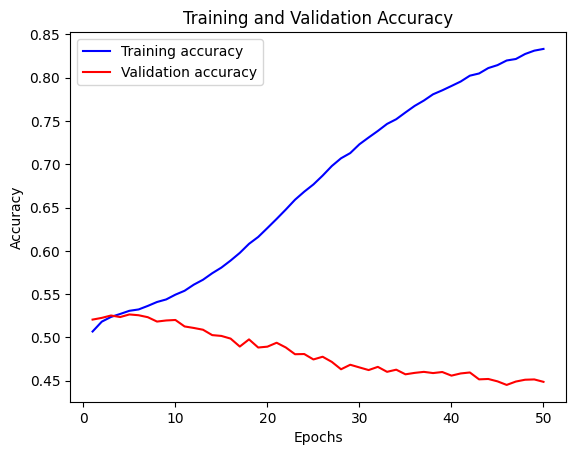

In [ ]:
import matplotlib.pyplot as plt

train_acc = mlp_model.history['accuracy']
val_acc = mlp_model.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Từ đồ thị biểu diễn Accuracy qua từng epoch, ta nhận thấy accuracy trên tập training tăng lên cao qua từng epoch nhưng accuracy trên tập validation thì giảm đi qua từng epoch. Điều này cho thấy mô hình đã bị overfitting nghiêm trọng và không có tính tổng quát với các mẫu dữ liệu mới.

In [ ]:
# classification report trên tập training
trainY_pred_encoded = model.predict(X_train_scaled)
trainY_pred = np.argmax(trainY_pred_encoded, axis=1)
trainY_pred = label_encoder.inverse_transform(trainY_pred)
print(classification_report(trainY, trainY_pred))
print()
# classification report trên tập testing
testY_pred_encoded = model.predict(X_test_scaled)
testY_pred = np.argmax(testY_pred_encoded, axis=1)
testY_pred = label_encoder.inverse_transform(testY_pred)
print(classification_report(testY, testY_pred))

3595/3595 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

           1       0.76      0.72      0.74     23729
           2       0.77      0.80      0.78     49478
           3       0.80      0.78      0.79     41809

    accuracy                           0.78    115016
   macro avg       0.78      0.77      0.77    115016
weighted avg       0.78      0.78      0.78    115016


1541/1541 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           1       0.34      0.32      0.33     10077
           2       0.46      0.49      0.47     21102
           3       0.48      0.47      0.48     18114

    accuracy                           0.45     49293
   macro avg       0.43      0.42      0.43     49293
weighted avg       0.44      0.45      0.44     49293



 Để tránh được overfitting của mô hình, ta thêm sẽ áp dụng phương pháp regularization trên model để kiểm soát các hyper-parameters quá lớn nhằm tăng tính tổng quát của mô hình trên các tập dữ liệu mới. Ở đây ta sẽ chọn regularization L2 norm.

Epoch 1/50
360/360 [==============================] - 4s 10ms/step - loss: 1.0550 - accuracy: 0.5050 - val_loss: 1.0195 - val_accuracy: 0.5216
Epoch 2/50
360/360 [==============================] - 5s 15ms/step - loss: 1.0075 - accuracy: 0.5189 - val_loss: 0.9944 - val_accuracy: 0.5206
Epoch 3/50
360/360 [==============================] - 3s 8ms/step - loss: 0.9879 - accuracy: 0.5198 - val_loss: 0.9804 - val_accuracy: 0.5240
Epoch 4/50
360/360 [==============================] - 3s 7ms/step - loss: 0.9757 - accuracy: 0.5242 - val_loss: 0.9743 - val_accuracy: 0.5244
Epoch 5/50
360/360 [==============================] - 3s 7ms/step - loss: 0.9687 - accuracy: 0.5247 - val_loss: 0.9677 - val_accuracy: 0.5235
Epoch 6/50
360/360 [==============================] - 4s 10ms/step - loss: 0.9631 - accuracy: 0.5266 - val_loss: 0.9631 - val_accuracy: 0.5276
Epoch 7/50
360/360 [==============================] - 3s 8ms/step - loss: 0.9598 - accuracy: 0.5280 - val_loss: 0.9616 - val_accuracy: 0.5266
Epo

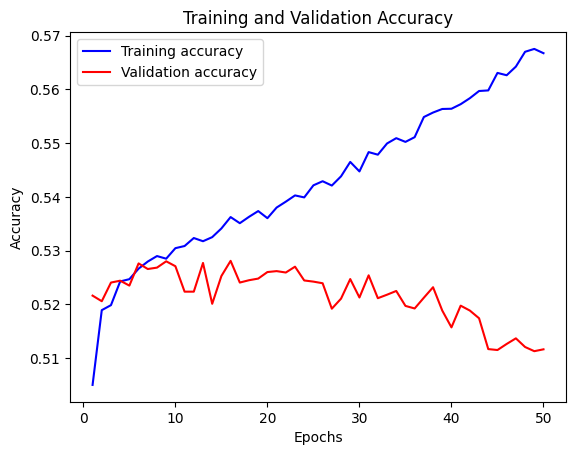

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(300, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
mlp_model = model.fit(X_train_scaled, trainY_encoder, epochs=50, batch_size=256, verbose=1, validation_split = 0.2)

train_acc = mlp_model.history['accuracy']
val_acc = mlp_model.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Quan sát đồ thị phía trên thì ta thấy accuracy của tập validation đạt được cao nhất chỉ là xấp xỉ 0.53 và kể từ đó nó sẽ bị giảm dần qua từng epoch trong khi accuracy trên tập training thì có xu hướng tăng đều qua từng epoch.

Ở mô hình này vẫn còn hiện tượng overfitting nếu như ta tăng số lượng epoch, điều này là do ta đã setup giá trị regularization L2 norm quá bé, do đó ta sẽ tăng giá trị regularization L2 trong mô hình lên. Giá trị này khi quá bé thì có thể làm mô hình dễ dàng mắc phải overfittinh nhưng khi quá lớn lại có thể làm cho model bị underfitting.

Epoch 1/50
360/360 [==============================] - 4s 8ms/step - loss: 1.2064 - accuracy: 0.5078 - val_loss: 1.0481 - val_accuracy: 0.5203
Epoch 2/50
360/360 [==============================] - 3s 7ms/step - loss: 1.0148 - accuracy: 0.5161 - val_loss: 0.9875 - val_accuracy: 0.5252
Epoch 3/50
360/360 [==============================] - 3s 9ms/step - loss: 0.9831 - accuracy: 0.5184 - val_loss: 0.9709 - val_accuracy: 0.5301
Epoch 4/50
360/360 [==============================] - 3s 8ms/step - loss: 0.9717 - accuracy: 0.5214 - val_loss: 0.9667 - val_accuracy: 0.5265
Epoch 5/50
360/360 [==============================] - 3s 7ms/step - loss: 0.9674 - accuracy: 0.5208 - val_loss: 0.9621 - val_accuracy: 0.5272
Epoch 6/50
360/360 [==============================] - 3s 7ms/step - loss: 0.9637 - accuracy: 0.5230 - val_loss: 0.9593 - val_accuracy: 0.5299
Epoch 7/50
360/360 [==============================] - 3s 9ms/step - loss: 0.9624 - accuracy: 0.5235 - val_loss: 0.9603 - val_accuracy: 0.5265
Epoch 

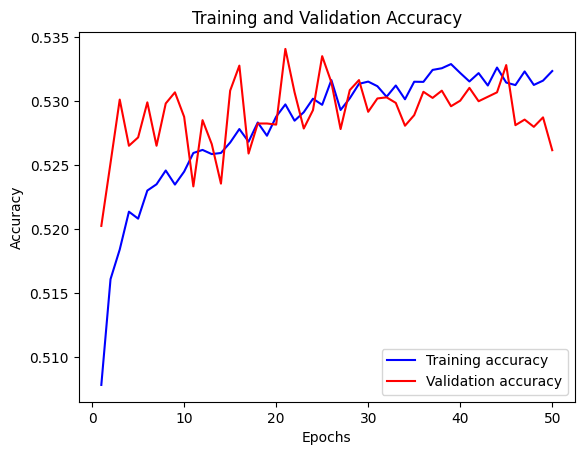

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(300, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
mlp_model = model.fit(X_train_scaled, trainY_encoder, epochs=50, batch_size=256, verbose=1, validation_split = 0.2)



train_acc = mlp_model.history['accuracy']
val_acc = mlp_model.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trải qua 50 epoch thì ta thấy không còn hiện tượng accuracy trên tập training tăng mà accuracy trên tập validation lại giảm đi nữa.

In [ ]:
training_loss, training_acc = model.evaluate(X_train_scaled, trainY_encoder)
print(f'Training Loss: {training_loss:.4f}')
print(f'Training Accuracy: {training_acc:.4f}')

print()

test_loss, test_acc = model.evaluate(X_test_scaled, testY_encoder)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

3595/3595 [==============================] - 7s 2ms/step - loss: 0.9436 - accuracy: 0.5333
Training Loss: 0.9436
Training Accuracy: 0.5333

1541/1541 [==============================] - 3s 2ms/step - loss: 0.9560 - accuracy: 0.5232
Test Loss: 0.9560
Test Accuracy: 0.5232


In [ ]:
trainY_pred_encoded = model.predict(X_train_scaled)
trainY_pred = np.argmax(trainY_pred_encoded, axis=1)

trainY_pred = label_encoder.inverse_transform(trainY_pred)
print(classification_report(trainY, trainY_pred))

print()

testY_pred_encoded = model.predict(X_test_scaled)
testY_pred = np.argmax(testY_pred_encoded, axis=1)

testY_pred = label_encoder.inverse_transform(testY_pred)

print(classification_report(testY, testY_pred))

3595/3595 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

           1       0.54      0.24      0.34     23729
           2       0.50      0.67      0.57     49478
           3       0.60      0.53      0.56     41809

    accuracy                           0.53    115016
   macro avg       0.55      0.48      0.49    115016
weighted avg       0.54      0.53      0.52    115016


1541/1541 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           1       0.52      0.23      0.32     10077
           2       0.49      0.66      0.56     21102
           3       0.59      0.52      0.55     18114

    accuracy                           0.52     49293
   macro avg       0.53      0.47      0.48     49293
weighted avg       0.53      0.52      0.51     49293



Bằng kỹ thuật L2 regularization ta đã tranh được hiện tượng overfitting của mô hình, Test Accuracy từ 0.45 ở mô hình phía trước đã tăng lên 0.52 ở mô hình hiện tại.

Ngoài ra, chúng ta còn có thể sử dụng phương pháp Dropout, là một phương pháp regularization phổ biến được sử dụng trong quá trình huấn luyện mạng nơ-ron để tránh hiện tượng overfitting. Trong TensorFlow, bạn có thể sử dụng dropout bằng cách sử dụng lớp tf.keras.layers.Dropout sau mỗi lớp neuron, với Dropout là tỷ lệ các đơn vị đầu vào sẽ bị bỏ qua ngẫu nhiên trong quá trình huấn luyện.

Tuy nhiên, ta quan sát thấy ở class 1 thì chỉ số Recall của class này không được cao, điều này có thể là do sự mất cân bằng giữa các lớp.

## Down-sampling

Theo như phân tích ở phần Preprocessing trước thì số lượng mẫu ở class 1 đang bị mất cân bằng so với class 2 và class 3, do đó ta sẽ áp dụng phương pháp down-sampling để lấy mẫu lại trên tập training nhằm giảm thiểu sự mất cân bằng giữa các lớp. Ở đây, ta sẽ sử dụng `TomekLinks()`.

In [ ]:
from imblearn.under_sampling import TomekLinks
np.random.seed(42)
down_sample = TomekLinks()
X_train_undersampling, y_train_undersampling = down_sample.fit_resample(X_train_scaled, trainY)

label_encoder = LabelEncoder()
trainY_under_encoder = label_encoder.fit_transform(y_train_undersampling) # mã hóa y down sampling

Sau đó, ta training lại model MLP với tập dữ liệu đã được down-sampling:

Epoch 1/50
287/287 - 3s - loss: 1.2500 - accuracy: 0.5064 - val_loss: 1.0844 - val_accuracy: 0.5204 - 3s/epoch - 10ms/step
Epoch 2/50
287/287 - 2s - loss: 1.0416 - accuracy: 0.5208 - val_loss: 1.0086 - val_accuracy: 0.5303 - 2s/epoch - 6ms/step
Epoch 3/50
287/287 - 2s - loss: 0.9964 - accuracy: 0.5256 - val_loss: 0.9844 - val_accuracy: 0.5305 - 2s/epoch - 6ms/step
Epoch 4/50
287/287 - 2s - loss: 0.9785 - accuracy: 0.5285 - val_loss: 0.9803 - val_accuracy: 0.5249 - 2s/epoch - 7ms/step
Epoch 5/50
287/287 - 3s - loss: 0.9700 - accuracy: 0.5303 - val_loss: 0.9665 - val_accuracy: 0.5309 - 3s/epoch - 10ms/step
Epoch 6/50
287/287 - 2s - loss: 0.9646 - accuracy: 0.5309 - val_loss: 0.9651 - val_accuracy: 0.5333 - 2s/epoch - 8ms/step
Epoch 7/50
287/287 - 2s - loss: 0.9615 - accuracy: 0.5333 - val_loss: 0.9623 - val_accuracy: 0.5302 - 2s/epoch - 7ms/step
Epoch 8/50
287/287 - 2s - loss: 0.9583 - accuracy: 0.5350 - val_loss: 0.9659 - val_accuracy: 0.5291 - 2s/epoch - 6ms/step
Epoch 9/50
287/287 - 2

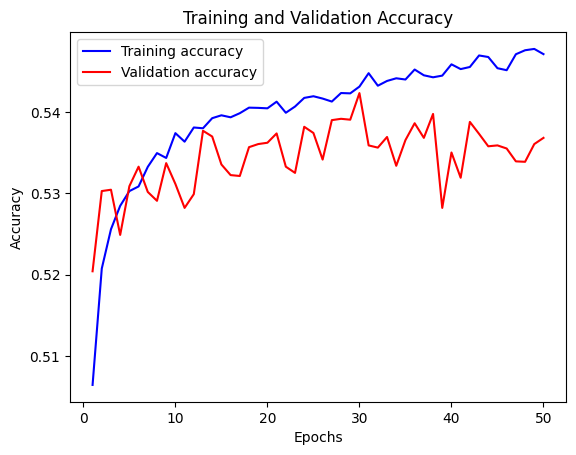

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(300, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
mlp_model = model.fit(X_train_undersampling, trainY_under_encoder, epochs=50, batch_size=256, verbose=2, validation_split = 0.2)


train_acc = mlp_model.history['accuracy']
val_acc = mlp_model.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
training_loss, training_acc = model.evaluate(X_train_scaled, trainY_encoder)
print(f'Training Loss: {training_loss:.4f}')
print(f'Training Accuracy: {training_acc:.4f}')

print()

test_loss, test_acc = model.evaluate(X_test_scaled, testY_encoder)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

3595/3595 [==============================] - 6s 2ms/step - loss: 0.9561 - accuracy: 0.5292
Training Loss: 0.9561
Training Accuracy: 0.5292

1541/1541 [==============================] - 3s 2ms/step - loss: 0.9764 - accuracy: 0.5137
Test Loss: 0.9764
Test Accuracy: 0.5137


In [ ]:
trainY_pred_encoded = model.predict(X_train_scaled)
trainY_pred = np.argmax(trainY_pred_encoded, axis=1)

trainY_pred = label_encoder.inverse_transform(trainY_pred)
print(classification_report(trainY, trainY_pred))

print()

testY_pred_encoded = model.predict(X_test_scaled)
testY_pred = np.argmax(testY_pred_encoded, axis=1)

testY_pred = label_encoder.inverse_transform(testY_pred)

print(classification_report(testY, testY_pred))

3595/3595 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           1       0.46      0.43      0.44     23729
           2       0.51      0.56      0.54     49478
           3       0.59      0.55      0.57     41809

    accuracy                           0.53    115016
   macro avg       0.52      0.51      0.52    115016
weighted avg       0.53      0.53      0.53    115016


1541/1541 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           1       0.43      0.41      0.42     10077
           2       0.50      0.54      0.52     21102
           3       0.58      0.54      0.56     18114

    accuracy                           0.51     49293
   macro avg       0.50      0.50      0.50     49293
weighted avg       0.51      0.51      0.51     49293



Khi áp dụng phương pháp down-sampling và bulid lại model, ta thấy recall ở class 1 đã được cải thiện lên rõ rệt, đồng thời chỉ số F1-score macro giữa các class cũng đã tăng lên 0.50, là mức cao nhất tính tới thời điểm hiện tại.

## Tuning hyper-parameters And Build Final MLP Model.

Với kết quả training phía trên, ta nhận xét được rằng khi thực hiện down-sampling thì model cho ra hiệu suất trên các class được đồng đều và trông có vẻ hài hòa hơn các model còn lại. Do đó, ta sẽ lấy model làm mô hình MLP chính thức và tinh chỉnh và tìm ra các hyper-parameters tối ưu nhất nhằm cải thiện hiệu suất mô hình.

Ở đây, chúng ta sẽ sử dụng Keras_tuner. Nó cho phép ta định nghĩa một không gian tìm kiếm siêu tham số và tự động thử nghiệm các cấu hình siêu tham số khác nhau để tìm ra cấu hình tốt nhất cho mô hình dựa trên một mục tiêu như độ chính xác (accuracy) hay hàm mất mát (loss).

Keras_tuner được xây dựng trên thư viện TensorFlow và hoạt động tốt với các mô hình được xây dựng bằng Keras hoặc TensorFlow. Nó cung cấp một cách tiện lợi để tối ưu hóa các siêu tham số và tăng cường hiệu suất của mô hình học máy.

Xây dựng một hypermodel cùng với không gian siêu tham số dùng để tìm kiếm: Ở đây, các tham số sẽ được tuning là số lượng đơn vị neuron ở từng lớp và learning_rate của thuật toán Adam.

In [ ]:
def model_builder(hp):

  model = tf.keras.Sequential()
  search_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32) # Số lượng units cho tầng đầu tiên
  search_units_2 = hp.Int('units_2', min_value=128, max_value=512, step=128) # Số lượng units cho tầng thứ hai
  search_units_3 = hp.Int('units_3', min_value=64, max_value=256, step=64) # Số lượng units cho tầng thứ ba
  search_units_4 = hp.Int('units_4', min_value=32, max_value=96, step=32) # Số lượng units cho tầng thứ tư

  l2_norm_1 = hp.Choice('l2_norm_1', values=[0.001, 0.005, 0.01, 0.015])
  l2_norm_2 = hp.Choice('l2_norm_2', values=[0.001, 0.005, 0.01, 0.015])
  l2_norm_3 = hp.Choice('l2_norm_3', values=[0.001, 0.005, 0.01, 0.015])
  l2_norm_4 = hp.Choice('l2_norm_4', values=[0.001, 0.005, 0.01, 0.015])

  model.add(tf.keras.layers.Dense(units=search_units_1, kernel_regularizer=regularizers.l2(l2_norm_1), activation='relu', input_shape=(41,)))
  model.add(tf.keras.layers.Dense(units=search_units_2, kernel_regularizer=regularizers.l2(l2_norm_2), activation='relu'))
  model.add(tf.keras.layers.Dense(units=search_units_3, kernel_regularizer=regularizers.l2(l2_norm_3), activation='relu'))
  model.add(tf.keras.layers.Dense(units=search_units_4, kernel_regularizer=regularizers.l2(l2_norm_4), activation='relu'))

  model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

  # Compile the model
  search_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # Các learning_rate trong không gian tìm kiếm
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=search_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
my_tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='final_mlp',
                     overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
my_tuner.search(X_train_undersampling, trainY_under_encoder, epochs=50, batch_size = 256, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.5140299201011658

Best val_accuracy So Far: 0.53084397315979
Total elapsed time: 00h 08m 25s


In [ ]:
best_hps = my_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of units in the first densely-connected layer is: {best_hps.get('units_1')}")
print(f"The optimal number of units in the second densely-connected layer is: {best_hps.get('units_2')}")
print(f"The optimal number of units in the third densely-connected layer is: {best_hps.get('units_3')}")
print(f"The optimal number of units in the fourth densely-connected layer is: {best_hps.get('units_4')}")
print(f"The optimal learning rate is: {best_hps.get('learning_rate')}")

The optimal number of units in the first densely-connected layer is: 96
The optimal number of units in the second densely-connected layer is: 512
The optimal number of units in the third densely-connected layer is: 128
The optimal number of units in the fourth densely-connected layer is: 32
The optimal learning rate is: 0.001


In [ ]:
print(f"The optimal kernel_regularizer l2_norm in the first densely-connected layer is: {best_hps.get('l2_norm_1')}")
print(f"The optimal kernel_regularizer l2_norm in the second densely-connected layer is: {best_hps.get('l2_norm_2')}")
print(f"The optimal kernel_regularizer l2_norm in the third densely-connected layer is: {best_hps.get('l2_norm_3')}")
print(f"The optimal kernel_regularizer l2_norm in the fourth densely-connected layer is: {best_hps.get('l2_norm_4')}")

The optimal kernel_regularizer l2_norm in the first densely-connected layer is: 0.01
The optimal kernel_regularizer l2_norm in the second densely-connected layer is: 0.001
The optimal kernel_regularizer l2_norm in the third densely-connected layer is: 0.005
The optimal kernel_regularizer l2_norm in the fourth densely-connected layer is: 0.005


Ta xem qua kiến trúc của mô hình MLP tốt nhất:

In [ ]:
best_model = my_tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                4032      
                                                                 
 dense_1 (Dense)             (None, 512)               49664     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 123,587
Trainable params: 123,587
Non-trainable params: 0
_________________________________________________________________


Ta training model MLP với các tham số tốt nhất với 50 epochs:

In [ ]:
model = my_tuner.hypermodel.build(best_hps)
history = model.fit(X_train_undersampling, trainY_under_encoder, batch_size = 256, epochs=50, validation_split=0.2)

Epoch 1/50
287/287 [==============================] - 4s 10ms/step - loss: 1.4367 - accuracy: 0.5010 - val_loss: 1.0460 - val_accuracy: 0.5194
Epoch 2/50
287/287 [==============================] - 3s 9ms/step - loss: 1.0157 - accuracy: 0.5169 - val_loss: 0.9964 - val_accuracy: 0.5203
Epoch 3/50
287/287 [==============================] - 3s 10ms/step - loss: 0.9945 - accuracy: 0.5182 - val_loss: 0.9907 - val_accuracy: 0.5194
Epoch 4/50
287/287 [==============================] - 5s 16ms/step - loss: 0.9883 - accuracy: 0.5195 - val_loss: 0.9837 - val_accuracy: 0.5260
Epoch 5/50
287/287 [==============================] - 3s 10ms/step - loss: 0.9844 - accuracy: 0.5216 - val_loss: 0.9849 - val_accuracy: 0.5248
Epoch 6/50
287/287 [==============================] - 3s 10ms/step - loss: 0.9820 - accuracy: 0.5223 - val_loss: 0.9803 - val_accuracy: 0.5253
Epoch 7/50
287/287 [==============================] - 3s 10ms/step - loss: 0.9806 - accuracy: 0.5226 - val_loss: 0.9755 - val_accuracy: 0.5303


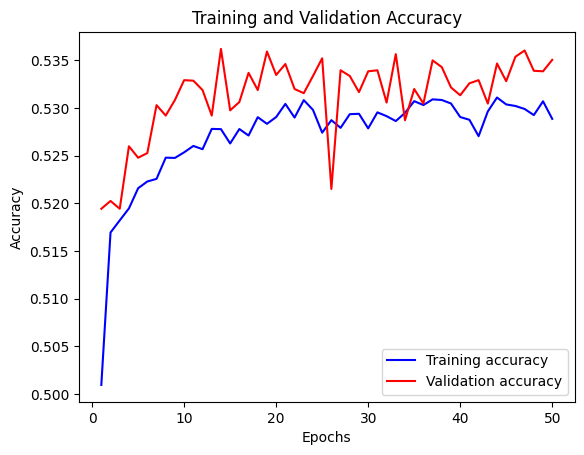

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ta thấy trong quá trình training, hiệu suất của mô hình trên tập validation luôn có xu hướng tốt hơn hiệu suất trên tập training.

In [ ]:
training_loss, training_acc = model.evaluate(X_train_scaled, trainY_encoder)
print(f'Training Loss: {training_loss:.4f}')
print(f'Training Accuracy: {training_acc:.4f}')
print()
test_loss, test_acc = model.evaluate(X_test_scaled, testY_encoder)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

3595/3595 [==============================] - 9s 2ms/step - loss: 0.9748 - accuracy: 0.5165
Training Loss: 0.9748
Training Accuracy: 0.5165

1541/1541 [==============================] - 3s 2ms/step - loss: 0.9804 - accuracy: 0.5107
Test Loss: 0.9804
Test Accuracy: 0.5107


## Final Model Performance

Đánh giá mô hình MLP chính thức trên tập training và tập testing: Với bài toán phân loại mức lãi suất cho vay này, ta sẽ chọn chỉ số F1 score macro để là tiêu chí đánh giá chính cho mô hình, điều này là ta muốn có sự đánh giá cân bằng được giữa Precision và Recall của các lớp.

In [ ]:
def calculate_performance(y_true, y_pred):

    print("precision", precision_score(y_true , y_pred, average = 'macro'))
    print("recall",recall_score(y_true , y_pred, average = 'macro'))
    print("accuracy", accuracy_score(y_true, y_pred))
    print("F1", f1_score(y_true , y_pred, average = 'macro'))

    main_score = f1_score(y_true , y_pred, average= 'macro') # Sử dụng F1 macro để đánh giá mô hình
    return main_score

In [ ]:
trainY_pred_encoded = model.predict(X_train_scaled) # Dự đoán trên tập training ban đầu
trainY_pred = np.argmax(trainY_pred_encoded, axis=1) # Gán vào lớp các xác suất cao nhất.
trainY_pred = label_encoder.inverse_transform(trainY_pred)
print(classification_report(trainY, trainY_pred))
print()
testY_pred_encoded = model.predict(X_test_scaled) # Dự đoán trên tập testing ban đầu
testY_pred = np.argmax(testY_pred_encoded, axis=1) # Gán vào lớp có xác suất cao nhất.
testY_pred = label_encoder.inverse_transform(testY_pred)
print(classification_report(testY, testY_pred))

3595/3595 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           1       0.44      0.42      0.43     23729
           2       0.51      0.49      0.50     49478
           3       0.56      0.60      0.58     41809

    accuracy                           0.52    115016
   macro avg       0.50      0.50      0.50    115016
weighted avg       0.51      0.52      0.52    115016


1541/1541 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           1       0.42      0.41      0.42     10077
           2       0.50      0.49      0.49     21102
           3       0.56      0.59      0.58     18114

    accuracy                           0.51     49293
   macro avg       0.50      0.50      0.50     49293
weighted avg       0.51      0.51      0.51     49293



In [ ]:
train_pred = model.predict(trainX)
print("Training performance:", calculate_performance(trainY, trainY_pred))
print()
test_pred = model.predict(testX)
print("Testing performance:", calculate_performance(testY, testY_pred))

3595/3595 [==============================] - 7s 2ms/step
precision 0.5041074370101605
recall 0.5039753764195537
accuracy 0.5165194407734576
F1 0.5037358838093633
Training performance: 0.5037358838093633

1541/1541 [==============================] - 5s 3ms/step
precision 0.4968632853342652
recall 0.4976132766425622
accuracy 0.5107013166169638
F1 0.4970257983120872
Testing performance: 0.4970257983120872


Mô hình MLP mà ta đã xây dựng cùng với các hyper-parameters có được từ quá trình tuning của Keras_tunner cho ra kết quả tương đối tốt:
- Khi xét về sự đồng đều của các metric trên các lớp, ta thấy mô hình có đáp ứng được tiêu chí này, mô hình không còn bị hụt ở các mẫu nằm trong class 1 như các mô hình MLP mà ta training ở phần trước.
- Đồng thời, ta sẽ chọn f1 score macro để là tiêu chí chính để đánh giá mô hình và ta cũng nhận được điểm số này trên mô hình là xấp xỉ 0.50, đây là mức cao nhất mà ta có được tính tới lúc hiện tại.


# Compare with other classification models.

Ta thực hiện so sánh với các mô hình phân lớp khác đã được học và thực hành trong chương trình. Bao gồm: Logistic Regression, Naive Bayes, Decision Tree, XGBoost và Support Vector Machine.

## Logistic Regression Model

Đầu tiên ta sẽ xây dựng mô hình phân loại sử dụng hồi quy logistic trên tập dữ liệu này:

In [ ]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline(steps=[("logistic", LogisticRegression(random_state = 42))])


param_grid = {
    "logistic__solver": ['lbfgs', 'liblinear', 'sag', 'saga'],
    "logistic__penalty": ['l1', 'l2']
    }

search = GridSearchCV(pipe, param_grid, scoring='f1_macro', n_jobs=2)
search.fit(X_train_undersampling, y_train_undersampling)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

Best parameter (CV score=0.495):
{'logistic__penalty': 'l2', 'logistic__solver': 'saga'}


Ta lấy kết quả các tham số từ GridSearchCV để traning mô hình Logistic Regression:

In [ ]:
def build_model(X, y):
    model = LogisticRegression(penalty = 'l2', solver = 'saga', random_state = 42)
    model.fit(X, y)
    return model

model = build_model(X_train_undersampling, y_train_undersampling)

predicted_label_train = model.predict(X_train_scaled)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = model.predict(X_test_scaled)
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

           1       0.44      0.29      0.35     23729
           2       0.50      0.58      0.54     49478
           3       0.56      0.56      0.56     41809

    accuracy                           0.51    115016
   macro avg       0.50      0.48      0.48    115016
weighted avg       0.51      0.51      0.51    115016


              precision    recall  f1-score   support

           1       0.43      0.29      0.34     10077
           2       0.49      0.58      0.53     21102
           3       0.56      0.55      0.55     18114

    accuracy                           0.51     49293
   macro avg       0.49      0.47      0.47     49293
weighted avg       0.50      0.51      0.50     49293



Bộ phân loại sử dụng hồi quy Logistic cho ra kết quả xấp xỉ với mô hình MLP phía trên về accuracy. Nhưng khi so về chỉ số f1 score macro thì mô hình Logistic đã có phần hụt hơi hơn MLP khi nó chỉ là 0.47.

## Naive Bayes Model

Tiếp theo, ta xây dựng mô hình phân loại bằng Naive Bayes, đây là một cơ chế phân loại dựa trên xác suất có điều kiện, nó giả sử sự độc lập xác suất của các thuộc tính. So với MLP thì mô hình này đơn giản hơn rất nhiều, nó dễ dàng được training cũng như sử dụng để phân lớp các mẫu.

In [ ]:
from sklearn.naive_bayes import GaussianNB

gau_nb = GaussianNB()
pipe = Pipeline(steps=[("gau_nb", gau_nb)])

var_smoothing_values = np.linspace(0, 1, 100)

param_grid = {
    'gau_nb__var_smoothing': var_smoothing_values
    }

nb_model = GridSearchCV(pipe, param_grid, scoring='f1_macro', n_jobs=2)
nb_model.fit(X_train_undersampling, y_train_undersampling)
print("Best parameter (CV score=%0.3f):" % nb_model.best_score_)
print(nb_model.best_params_)

Best parameter (CV score=0.443):
{'gau_nb__var_smoothing': 0.0}


In [ ]:
predicted_label_train = nb_model.predict(X_train_scaled)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = nb_model.predict(X_test_scaled)
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

           1       0.38      0.21      0.27     23729
           2       0.48      0.68      0.56     49478
           3       0.55      0.41      0.47     41809

    accuracy                           0.48    115016
   macro avg       0.47      0.43      0.43    115016
weighted avg       0.48      0.48      0.47    115016


              precision    recall  f1-score   support

           1       0.36      0.21      0.27     10077
           2       0.47      0.68      0.56     21102
           3       0.55      0.40      0.47     18114

    accuracy                           0.48     49293
   macro avg       0.46      0.43      0.43     49293
weighted avg       0.48      0.48      0.46     49293



Đối với mô hình phân loại sử dụng GaussianNB() cho ra kết quả tương đối thấp khi so sánh với các mô hình MLP và Logistic Regression. Kết quả đều tệ hơn hai model trên cả về accuracy cũng như F1 score.

## Decision Tree Model

Tiếp theo, ta xây dựng một model phân loại dựa trên Decision Tree:

In [ ]:
#pipe = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state = 42))])

#parameters = {'classifier__max_depth': [2, 4, 8, 10, 12],
#              'classifier__ccp_alpha': [0.0001, 0.00015, 0.00017, 0.0002],
#              'classifier__criterion': ["gini", "entropy", "log_loss"],
#             'classifier__min_samples_leaf':[1, 2, 3, 5, 7, 9],
#             'classifier__min_samples_split': [2, 3 , 5, 7, 9]}

#decision_tree_grid_model = GridSearchCV(pipe, parameters, scoring='f1_macro', cv = 2, n_jobs = 2)
#decision_tree_grid_model.fit(X_train_undersampling, y_train_undersampling)
#print("Best parameter (CV score = %0.3f):" % decision_tree_grid_model.best_score_)
#print(decision_tree_grid_model.best_params_)

In [ ]:
def build_model(X, y):
    model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf = 5, min_samples_split = 7)
    model = pipe.fit(X, y)
    return model

dec_model = build_model(X_train_undersampling, y_train_undersampling)

predicted_label_train = dec_model.predict(X_train_scaled)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = dec_model.predict(X_test_scaled)
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

           1       0.38      0.21      0.27     23729
           2       0.48      0.68      0.56     49478
           3       0.55      0.41      0.47     41809

    accuracy                           0.48    115016
   macro avg       0.47      0.43      0.43    115016
weighted avg       0.48      0.48      0.47    115016


              precision    recall  f1-score   support

           1       0.36      0.21      0.27     10077
           2       0.47      0.68      0.56     21102
           3       0.55      0.40      0.47     18114

    accuracy                           0.48     49293
   macro avg       0.46      0.43      0.43     49293
weighted avg       0.48      0.48      0.46     49293



Tương tự thì Decision Tree Classifier cũng không cho ra kết quả quá cao khi so sánh với mô hình MLP.

Mô hình Desicion Tree này cũng có hiệu suất tương đương với với mô hình Naive Bayes trước đó.

## XGBoost Model

Tiếp theo, ta sử dụng thuật toán XGBoots để xây dựng một mô hình phân loại tiếp theo. Đây là một trong những thuật toán máy học mạnh hàng đầu hiện nay, dựa trên Decision Tree. Mô hình XGBoost xây dựng một tập hợp các cây quyết định tuần tự, trong đó mỗi cây đại diện cho một vòng lặp trong quá trình boosting.

In [ ]:
le = LabelEncoder()
xgb_y_train_undersampling = le.fit_transform(y_train_undersampling)

XGB_model = XGBClassifier(eta = 0.01, max_depth=10, seed= 42, reg_lambda = 1.5)
XGB_model.fit(X_train_undersampling, xgb_y_train_undersampling)

predicted_label_train = XGB_model.predict(X_train_scaled)
predicted_label_train = le.inverse_transform(predicted_label_train)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = XGB_model.predict(X_test_scaled)
predicted_label_test = le.inverse_transform(predicted_label_test)
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

           1       0.53      0.45      0.49     23729
           2       0.57      0.62      0.59     49478
           3       0.62      0.60      0.61     41809

    accuracy                           0.58    115016
   macro avg       0.57      0.56      0.57    115016
weighted avg       0.58      0.58      0.58    115016


              precision    recall  f1-score   support

           1       0.44      0.38      0.41     10077
           2       0.50      0.55      0.53     21102
           3       0.57      0.55      0.56     18114

    accuracy                           0.52     49293
   macro avg       0.50      0.49      0.50     49293
weighted avg       0.51      0.52      0.51     49293



Ta thấy mô hình XGBoostClassifier đã xây dựng đạt kết quả có phần tốt hơn so với mô hình MLP khi chỉ đến xét chỉ số Accuracy. Chỉ số accuracy trên tập training cũng như testing đã cao hơn so với MLP, nhưng khi so về chỉ số F1 score macro, ta thấy cả 2 mô hình là MLP và XGBoost đều ngang bằng với nhau. Nhưng ta để ý đến class 1 của mô hình XGBoost này thì ta thấy chỉ số recall và F1 đã thấp hơn một tí so với MLP.

Một điểm cộng của XGBoost là có thời gian training nhanh hơn so với MLP mà đã có kết quả tương đối như thế này.

## Support Vector Machine Model

Ta thực hiện tiếp một bộ phân loại sử dụng SVM:

In [ ]:
def build_model(X, y):
    model = SVC(kernel='rbf', C=1.0, gamma='scale')
    model = pipe.fit(X, y)
    return model

svm_model = build_model(X_train_undersampling, y_train_undersampling)

predicted_label_train = svm_model.predict(X_train_scaled)
print(classification_report(trainY, predicted_label_train))
print()
predicted_label_test = svm_model.predict(X_test_scaled)
print(classification_report(testY, predicted_label_test))

              precision    recall  f1-score   support

           1       0.38      0.21      0.27     23729
           2       0.48      0.68      0.56     49478
           3       0.55      0.41      0.47     41809

    accuracy                           0.48    115016
   macro avg       0.47      0.43      0.43    115016
weighted avg       0.48      0.48      0.47    115016


              precision    recall  f1-score   support

           1       0.36      0.21      0.27     10077
           2       0.47      0.68      0.56     21102
           3       0.55      0.40      0.47     18114

    accuracy                           0.48     49293
   macro avg       0.46      0.43      0.43     49293
weighted avg       0.48      0.48      0.46     49293



Mô hình phân loại SVC đã xây dựng phía trên đạt kết quả không tốt trên cả tập dữ liệu kiểm tra và tập dữ liệu huấn luyện khi đem so sánh với mô hình MLP mà ta đã xây dựng. Nó có cùng hiệu suất với hai mô hình Naive Bayes và Decision Tree.

Dựa trên các mô hình đã xây dựng trên, ta có thể đưa ra nhận xét sau:
- Nhìn chung các mô hình Naive bayes, Desicion Tree và SVM có hiệu suất tương đương với nhau. Có hiệu suất cao hơn 3 mô hình này một tí là mô hình Logistic Regression. Tuy nhiên, tất cả các mô hình này đều không tốt hơn khi so với mô hình MLP mà ta đã có được từ phía trước.
- Mô hình phân loại được xây dựng với XGBoots cho ra kết quả hiệu suất xấp xỉ so với MLP, tuy nhiên lại có vẻ hụt hơn MLP ở class 1 (nếu xết về chỉ số Recall và F1).


# Conclusion

MLP (Multilayer Perceptron) là mô hình mạng neural nhân tạo đa tầng, được sử dụng để giải quyết các bài toán phân loại và dự đoán. Chính cấu trúc này đã giúp MLP có thể học được nhiều từ dữ liệu đầu vào hơn, bên cạnh đó nhờ vào các hàm kích hoạt phi tuyến cũng như quá trình lan truyền ngược đã giúp MLP có khả năng tự động học các đặc trưng từ dữ liệu mà không cần sự can thiệp tay công của con người trong quá trình feature engineering truyền thống, từ đó có thể tiết kiệm được thời gian và tăng được hiệu suất phân loại.

Tuy nhiên, MLP cũng có một khuyết điểm là sự kết nối đầy đủ (fully connected), điều này đã làm số lượng tham số trở nên quá lớn nếu như mô hình có cấu tạo phức tạp, từ đó làm cồng kềnh và tăng thời gian training.

Độ sâu (số lượng tầng hidden) của một mô hình MLP là sự lựa chọn cần được cân nhắc kỹ, vì không phải một một hình deep learning càng sâu là sẽ càng tốt. Một mô hình nếu đã có độ sâu đủ tốt thì có sâu thêm nữa cũng không thể cải thiện được hiệu suất, thậm chí là có thể giảm đi. Lúc này ta sẽ tốn nhiều thời gian để training cũng như mô hình sẽ cồng kềnh hơn, thậm chí là mô hình sẽ không thể hội tụ được.

Mô hình MLP phía trên chưa phải là mô hình tốt nhất vì hiệu suất phân loại vẫn chưa được tốt nhất. Dựa trên quan sát (trong bài làm này) trong quá trình huấn luyện và đánh giá bằng tập validation, ta thấy tập dữ liệu này có lẽ sẽ không đạt được hiệu suất quá cao. Các mô hình rất dễ bị overfitting từ sớm, hiệu suất trên tập training thì rất tốt và được cải thiện qua từng epoch nhưng hiệu suất trên tập validation thì chỉ đâu đó hơn 0.53 (accuracy) là bắt đầu giảm xuống.

Khi so sánh với các mô hình phân lớp khác trong chương trình đã học thì ta thấy đa số các mô hình đều không tốt hơn MLP, trong đó có một mô hình đạt được hiệu suất khá xấp xỉ với MLP là mô hình sử dụng XGBoost.

Mô hình MLP mà ta đã training phía trên vẫn có thể được cải thiện thêm nhờ áp dụng các kỹ thuật xử lý tốt hơn, hiệu quả hơn ở phần data preprocessing hoặc data engineering, cũng như dành thêm nhiều thời gian hơn để tìm hiểu và tuning các hyperparameter của mô hình.